In [1]:
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing import image

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(#rotation_range=15,
                              # width_shift_range=0.1,
                               #height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               preprocessing_function = preprocess_input)

Using TensorFlow backend.


In [5]:
train = datagen.flow_from_directory('Train', shuffle = True,target_size=[224,224], batch_size = 2019)
test = datagen.flow_from_directory('Test', shuffle = True, target_size=[224,224], batch_size = 202)
valid = datagen.flow_from_directory('Valid',shuffle = True, target_size=[224,224], batch_size = 278)

Found 2019 images belonging to 5 classes.
Found 202 images belonging to 5 classes.
Found 278 images belonging to 5 classes.


In [6]:
len(train)

1

In [7]:
len(test)

1

In [8]:
X_train, y_train = train.next()
X_test, y_test = test.next()
X_valid, y_valid = valid.next()

In [9]:
#X_train = X_train.reshape([-1,224,224,3])

In [9]:
X_train.shape

(2019, 224, 224, 3)

In [11]:
type(X_train[11])

numpy.ndarray

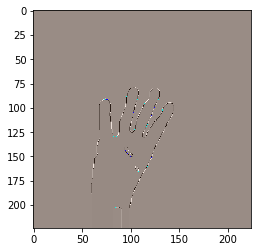

In [11]:
plt.imshow(X_train[1].astype('uint8'))

In [12]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [13]:
y_train.shape
y_train = np.argmax(y_train, axis = 1)
y_valid = np.argmax(y_valid, axis = 1)
y_test = np.argmax(y_test, axis = 1)
y_train

array([4, 3, 0, ..., 2, 1, 1])

In [14]:
y_train.shape

(2019,)

In [15]:
X_valid.shape

(278, 224, 224, 3)

In [16]:
y_valid.shape

(278,)

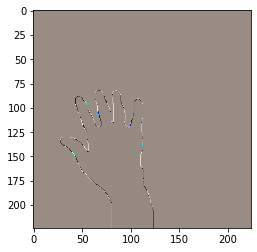

In [17]:
plt.imshow(X_train[11].astype('uint8'))

In [18]:
net = resnet.ResNet101(input_shape=(224,224,3), weights = 'imagenet', include_top = False, classes = 5)

In [19]:
for layer in net.layers[:-5]:
    layer.trainable = False
    

In [20]:
x = Flatten()(net.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(5, activation = 'softmax')(x)
m = Model(net.input, x)

In [21]:
m.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr = 2*(1e-6)), metrics = ['accuracy'])

In [22]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 4)

In [24]:
history = m.fit(X_train, y_train,
                shuffle=True,
                batch_size = 32,
                epochs = 35,
                validation_data= (X_valid, y_valid),
                callbacks=[es]
                )

Train on 2019 samples, validate on 278 samples
Epoch 1/35
2019/2019 [==============================] - 179s 89ms/sample - loss: 2.1403 - accuracy: 0.3432 - val_loss: 1.5782 - val_accuracy: 0.3885
Epoch 2/35
2019/2019 [==============================] - 175s 87ms/sample - loss: 1.2982 - accuracy: 0.5409 - val_loss: 1.3807 - val_accuracy: 0.4712
Epoch 3/35
2019/2019 [==============================] - 175s 87ms/sample - loss: 0.9091 - accuracy: 0.6766 - val_loss: 1.2757 - val_accuracy: 0.4964
Epoch 4/35
2019/2019 [==============================] - 178s 88ms/sample - loss: 0.6710 - accuracy: 0.7509 - val_loss: 1.2473 - val_accuracy: 0.4892
Epoch 5/35
2019/2019 [==============================] - 180s 89ms/sample - loss: 0.5482 - accuracy: 0.7920 - val_loss: 1.2302 - val_accuracy: 0.4928
Epoch 6/35
2019/2019 [==============================] - 174s 86ms/sample - loss: 0.4329 - accuracy: 0.8375 - val_loss: 1.2523 - val_accuracy: 0.4892
Epoch 7/35
2019/2019 [==============================] - 175

In [46]:
m.evaluate(X_test, y_test)

202/202 [==============================] - 11s 54ms/sample - loss: 0.5544 - accuracy: 0.7772


[0.5543525050772299, 0.7772277]

In [29]:
predictions = m.predict(X_test)
rounded_labels = np.argmax(predictions, axis=1)
rounded_labels[1]



1

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rounded_labels))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        35
           1       0.76      0.74      0.75        34
           2       0.76      0.83      0.79        53
           3       0.64      0.78      0.70        41
           4       0.85      0.72      0.78        39

    accuracy                           0.78       202
   macro avg       0.80      0.77      0.78       202
weighted avg       0.79      0.78      0.78       202



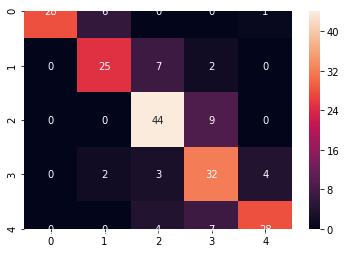

In [31]:
cm = confusion_matrix(y_test, rounded_labels)
sns.heatmap(cm, annot = True)

In [32]:
rounded_labels

array([0, 1, 3, 1, 2, 4, 0, 3, 2, 3, 1, 1, 2, 3, 2, 2, 2, 4, 2, 4, 2, 3,
       0, 3, 2, 2, 1, 0, 3, 1, 3, 3, 3, 2, 0, 0, 4, 4, 1, 2, 1, 4, 2, 4,
       1, 4, 0, 3, 1, 2, 1, 2, 3, 2, 1, 3, 3, 4, 0, 2, 2, 4, 3, 2, 1, 3,
       1, 3, 4, 1, 2, 4, 3, 2, 2, 4, 0, 4, 4, 2, 1, 3, 2, 3, 2, 0, 1, 1,
       3, 3, 2, 1, 1, 2, 4, 4, 3, 1, 4, 0, 2, 3, 3, 3, 0, 2, 1, 0, 0, 4,
       1, 2, 2, 1, 3, 4, 0, 4, 0, 4, 2, 3, 3, 3, 4, 2, 1, 2, 2, 1, 1, 4,
       1, 3, 4, 1, 4, 2, 3, 2, 2, 3, 3, 4, 3, 0, 3, 2, 3, 2, 4, 2, 0, 2,
       3, 2, 3, 3, 1, 1, 0, 2, 0, 3, 3, 2, 2, 3, 2, 2, 0, 0, 0, 2, 4, 3,
       1, 4, 2, 0, 4, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 3, 4, 4, 0, 0, 0, 3,
       1, 3, 3, 3])

In [33]:
y_test

array([0, 1, 3, 1, 2, 4, 0, 4, 2, 3, 1, 1, 2, 1, 2, 2, 2, 4, 1, 4, 3, 4,
       0, 2, 2, 2, 1, 0, 3, 0, 3, 3, 2, 4, 0, 0, 3, 4, 1, 2, 3, 4, 2, 4,
       1, 0, 0, 3, 1, 2, 1, 1, 3, 3, 1, 4, 3, 4, 0, 2, 2, 4, 3, 2, 0, 3,
       1, 2, 3, 1, 2, 4, 2, 1, 2, 3, 0, 4, 4, 2, 1, 4, 2, 2, 1, 0, 1, 1,
       2, 3, 2, 1, 1, 2, 4, 4, 2, 3, 4, 0, 2, 3, 3, 2, 0, 2, 1, 0, 0, 4,
       0, 2, 2, 0, 3, 4, 0, 4, 0, 4, 2, 3, 3, 3, 4, 2, 1, 4, 4, 1, 0, 4,
       1, 3, 4, 1, 4, 2, 3, 1, 2, 4, 3, 4, 3, 0, 4, 2, 3, 2, 4, 2, 0, 3,
       4, 2, 3, 3, 1, 0, 0, 1, 0, 3, 2, 2, 1, 3, 2, 2, 0, 0, 0, 4, 4, 3,
       1, 4, 2, 0, 3, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 3, 4, 4, 0, 0, 0, 3,
       1, 3, 3, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


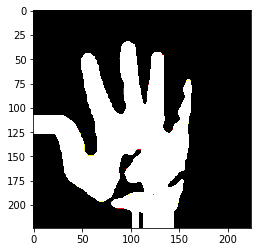

In [34]:
plt.imshow(X_test[5])

In [40]:
# import json
# json_file = m.to_json()
# with open('Saved_models/final1', "w") as file:
#     #f.close()

#     file.write(json_file)
# #serialize weights to HDF5
# m.save_weights('final_model1.h5')

In [36]:
#m.save_weights('Saved_models/m1.h5')

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

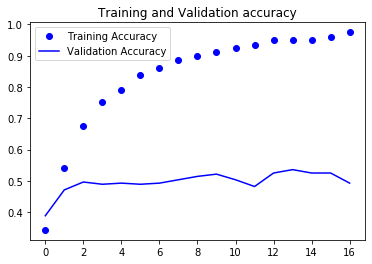

In [41]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
#fig = plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()


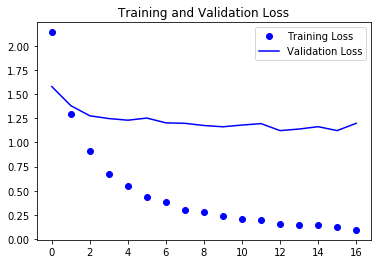

In [44]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()